In [595]:
import json
import requests
import time
import pandas as pd

import os
from os.path import join, dirname
from dotenv import load_dotenv


dotenv_path = join(dirname(os.path.dirname('__file__')), '.env')
load_dotenv(dotenv_path)

from sqlalchemy import create_engine

# build connecting string from .env
DATABASE_NAME = os.getenv("SNAPSHOT_PUBLIC_DB_NAME")
DATABASE_USER = os.getenv("SNAPSHOT_PUBLIC_DB_USER")
DATABASE_PASSWORD = os.getenv("SNAPSHOT_PUBLIC_DB_PASSWORD")
DATABASE_HOST = os.getenv("SNAPSHOT_PUBLIC_DB_HOST")
DATABASE_PORT = os.getenv("SNAPSHOT_PUBLIC_DB_PORT")

connection = "postgresql://"+DATABASE_USER+":"+DATABASE_PASSWORD+"@"+DATABASE_HOST+":"+DATABASE_PORT+"/"+DATABASE_NAME

conn = create_engine(connection) 

In [1009]:
engine_govglads = create_engine(os.getenv("GOVGLADS_DB_URL")) 

98

In [703]:
# arbitrumfoundation.eth
import numpy as np

arbitrum_proposal_query = "SELECT * FROM snapshot.proposallist WHERE dao_id = 'arbitrumfoundation.eth'"
arbitrum_proposal_df = pd.read_sql_query(arbitrum_proposal_query, conn)
arbitrum_votes = f"""
    SELECT * from snapshot.votelist where proposal IN {tuple(arbitrum_proposal_df['proposal_id'])};
"""
arbitrum_votes_df = pd.read_sql_query(arbitrum_votes, conn)

arbitrum_votes_df['choice'] = arbitrum_votes_df['choice'].astype(str)
arbitrum_votes_grouped = arbitrum_votes_df.groupby(['proposal', 'choice']).agg({'vp': 'sum'}).reset_index()

# new df with proposal, and percent of majority choice and the majority choice
arbitrum_votes_grouped['percent'] = arbitrum_votes_grouped.groupby('proposal')['vp'].transform(lambda x: x / x.sum())
arbitrum_votes_grouped['percent'] = arbitrum_votes_grouped['percent'].replace(np.nan, 0)
arbitrum_votes_grouped = arbitrum_votes_grouped[arbitrum_votes_grouped['percent'] > 0.5]
arbitrum_votes_grouped['majority_choice'] = arbitrum_votes_grouped['choice']
arbitrum_votes_grouped = arbitrum_votes_grouped.drop(columns=['choice'])

arbitrum_votes = f"""
    SELECT * from snapshot.votelist where proposal IN {tuple(arbitrum_votes_grouped['proposal'])};
"""
arbitrum_votes_df = pd.read_sql_query(arbitrum_votes, conn)

# remove vote_id, app, reason, typename
arbitrum_votes_df = arbitrum_votes_df.drop(columns=['vote_id', 'app', 'reason', 'typename'])
# join proposals on proposal and proposal_id
arbitrum_votes_and_proposals = pd.merge(arbitrum_votes_df, arbitrum_proposal_df, left_on='proposal', right_on='proposal_id')
# drop proposal_id, plugins, discussion, ipfs, app, link, privacy, flagged
arbitrum_votes_and_proposals = arbitrum_votes_and_proposals.drop(columns=['proposal_id', 'plugins', 'discussion', 'ipfs', 'app', 'link', 'privacy', 'flagged'])
# drop created_x; rename created_y to created
arbitrum_votes_and_proposals = arbitrum_votes_and_proposals.drop(columns=['created_x'])
arbitrum_votes_and_proposals = arbitrum_votes_and_proposals.rename(columns={'created_y':'created'})
# drop vp bellow 10000
arbitrum_votes_and_proposals = arbitrum_votes_and_proposals[arbitrum_votes_and_proposals['vp'] > 10000]
# clone df with proposal_id, voter, vp, choice, created
arbitrum_votes_and_proposals_clone = arbitrum_votes_and_proposals.copy()
arbitrum_votes_shallow = arbitrum_votes_and_proposals_clone[['proposal', 'voter', 'vp', 'choice', 'created']]
arbitrum_votes_shallow



,proposal,voter,vp,choice,created
316,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x1FD8271f95b32EcFFAdE04a2C93C7009b6Fe7d5F,11310.000000,1,1.679955e+09
711,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x8D470921050899284b451d6a65f4204Eee4aaf8f,63627.000000,1,1.679955e+09
825,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x8719A15457C5107417966873d2A4b16b8478B873,15000.177205,1,1.679955e+09
929,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x70F8A0A356e4391c90721355158cca09E38B265e,23640.000000,1,1.679955e+09
980,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0xE4b217F63fA4b9b10C87d2eae0D4a1065c6549a7,21179.000000,1,1.679955e+09
...,...,...,...,...,...
2895388,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0xC8bDec0F09A4CF86d0245021bc0cAE9Ab24a2065,50000.920000,1,1.680919e+09
2895547,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0xc6a0D3C3D306CBb0915013cb6a7C45B89F804703,29083.007088,2,1.680919e+09
2896466,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0x5bFfCD8F4809E29bCAcE4C9c21e0C3b6963eCec1,38267.025980,2,1.680919e+09
2896468,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0x150c1a37F58c976160E7933fc474DC8a5390FF1E,109409.382238,2,1.680919e+09


In [655]:
# 1inch.eth
import numpy as np

oneinch_proposal_query = "SELECT * FROM snapshot.proposallist WHERE dao_id = '1inch.eth'"
oneinch_proposal_df = pd.read_sql_query(oneinch_proposal_query, conn)
oneinch_votes = f"""
    SELECT * from snapshot.votelist where proposal IN {tuple(oneinch_proposal_df['proposal_id'])};
"""
oneinch_votes_df = pd.read_sql_query(oneinch_votes, conn)

oneinch_votes_df['choice'] = oneinch_votes_df['choice'].astype(str)
oneinch_votes_grouped = oneinch_votes_df.groupby(['proposal', 'choice']).agg({'vp': 'sum'}).reset_index()

# new df with proposal, and percent of majority choice and the majority choice
oneinch_votes_grouped['percent'] = oneinch_votes_grouped.groupby('proposal')['vp'].transform(lambda x: x / x.sum())
oneinch_votes_grouped['percent'] = oneinch_votes_grouped['percent'].replace(np.nan, 0)
oneinch_votes_grouped = oneinch_votes_grouped[oneinch_votes_grouped['percent'] > 0.5]
oneinch_votes_grouped['majority_choice'] = oneinch_votes_grouped['choice']
oneinch_votes_grouped = oneinch_votes_grouped.drop(columns=['choice'])

oneinch_votes = f"""
    SELECT * from snapshot.votelist where proposal IN {tuple(oneinch_votes_grouped['proposal'])};
"""
oneinch_votes_df = pd.read_sql_query(oneinch_votes, conn)

# remove vote_id, app, reason, typename
oneinch_votes_df = oneinch_votes_df.drop(columns=['vote_id', 'app', 'reason', 'typename'])
# join proposals on proposal and proposal_id
oneinch_votes_and_proposals = pd.merge(oneinch_votes_df, oneinch_proposal_df, left_on='proposal', right_on='proposal_id')
# drop proposal_id, plugins, discussion, ipfs, app, link, privacy, flagged
oneinch_votes_and_proposals = oneinch_votes_and_proposals.drop(columns=['proposal_id', 'plugins', 'discussion', 'ipfs', 'app', 'link', 'privacy', 'flagged'])
# drop created_x; rename created_y to created
oneinch_votes_and_proposals = oneinch_votes_and_proposals.drop(columns=['created_x'])
oneinch_votes_and_proposals = oneinch_votes_and_proposals.rename(columns={'created_y':'created'})
# drop vp bellow 10000
oneinch_votes_and_proposals = oneinch_votes_and_proposals[oneinch_votes_and_proposals['vp'] > 100]
# clone df with proposal_id, voter, vp, choice, created
oneinch_votes_and_proposals_clone = oneinch_votes_and_proposals.copy()
oneinch_votes_shallow = oneinch_votes_and_proposals_clone[['proposal', 'voter', 'vp', 'choice', 'created']]
oneinch_votes_shallow



,proposal,voter,vp,choice,created
3,QmU5rSEMyb9qpPqWUoaJBoTiH6XjBknnojUsXirFxeRjHr,0x1e92842D072dD2c71183af24458B013F678F9D3d,1000.000000,1,1.627828e+09
4,QmU5rSEMyb9qpPqWUoaJBoTiH6XjBknnojUsXirFxeRjHr,0x76Da9F88e63a85Ba8BFA19F3821D5A271753D3dc,253.272266,1,1.627828e+09
5,QmU5rSEMyb9qpPqWUoaJBoTiH6XjBknnojUsXirFxeRjHr,0x3ab5c2ac327C3044776A2c229Cb9c16bA9dCDBEe,173.986372,1,1.627828e+09
6,QmU5rSEMyb9qpPqWUoaJBoTiH6XjBknnojUsXirFxeRjHr,0x23Ed05AaD698cD4bE7c9c5F2C6F8c04ed1827793,462.606722,1,1.627828e+09
7,QmU5rSEMyb9qpPqWUoaJBoTiH6XjBknnojUsXirFxeRjHr,0xE86e28a0653736e76B78eaD692F0c287709D2Dd9,39990.000090,1,1.627828e+09
...,...,...,...,...,...
11055,0xd22d83201c9b65eb42e889ed2b6416c0e0331345ab9e...,0x986D37258f86299E62eC0D208E2d46caA0298dBF,7486.641202,1,1.699871e+09
11063,0xd22d83201c9b65eb42e889ed2b6416c0e0331345ab9e...,0x087DD253ec7d42e3008ee8C0eA06D1237f08B99C,382.054233,1,1.699871e+09
11065,0xd22d83201c9b65eb42e889ed2b6416c0e0331345ab9e...,0x8F0F70c8828801d3d88D3B53e2f65B82de5acCab,119752.889219,3,1.699871e+09
11072,0xd22d83201c9b65eb42e889ed2b6416c0e0331345ab9e...,0xf6542152B0e4113375BA1FbCed8913270EdfBd6c,331.931877,1,1.699871e+09


In [654]:
# apecoin.eth
import numpy as np

apecoin_proposal_query = "SELECT * FROM snapshot.proposallist WHERE dao_id = 'apecoin.eth'"
apecoin_proposal_df = pd.read_sql_query(apecoin_proposal_query, conn)
apecoin_votes = f"""
    SELECT * from snapshot.votelist where proposal IN {tuple(apecoin_proposal_df['proposal_id'])};
"""
apecoin_votes_df = pd.read_sql_query(apecoin_votes, conn)

apecoin_votes_df['choice'] = apecoin_votes_df['choice'].astype(str)
apecoin_votes_grouped = apecoin_votes_df.groupby(['proposal', 'choice']).agg({'vp': 'sum'}).reset_index()

# new df with proposal, and percent of majority choice and the majority choice
apecoin_votes_grouped['percent'] = apecoin_votes_grouped.groupby('proposal')['vp'].transform(lambda x: x / x.sum())
apecoin_votes_grouped['percent'] = apecoin_votes_grouped['percent'].replace(np.nan, 0)
apecoin_votes_grouped = apecoin_votes_grouped[apecoin_votes_grouped['percent'] > 0.5]
apecoin_votes_grouped['majority_choice'] = apecoin_votes_grouped['choice']
apecoin_votes_grouped = apecoin_votes_grouped.drop(columns=['choice'])

apecoin_votes = f"""
    SELECT * from snapshot.votelist where proposal IN {tuple(apecoin_votes_grouped['proposal'])};
"""
apecoin_votes_df = pd.read_sql_query(apecoin_votes, conn)

# remove vote_id, app, reason, typename
apecoin_votes_df = apecoin_votes_df.drop(columns=['vote_id', 'app', 'reason', 'typename'])
# join proposals on proposal and proposal_id
apecoin_votes_and_proposals = pd.merge(apecoin_votes_df, apecoin_proposal_df, left_on='proposal', right_on='proposal_id')
# drop proposal_id, plugins, discussion, ipfs, app, link, privacy, flagged
apecoin_votes_and_proposals = apecoin_votes_and_proposals.drop(columns=['proposal_id', 'plugins', 'discussion', 'ipfs', 'app', 'link', 'privacy', 'flagged'])
# drop created_x; rename created_y to created
apecoin_votes_and_proposals = apecoin_votes_and_proposals.drop(columns=['created_x'])
apecoin_votes_and_proposals = apecoin_votes_and_proposals.rename(columns={'created_y':'created'})
# drop vp bellow 10000
apecoin_votes_and_proposals = apecoin_votes_and_proposals[apecoin_votes_and_proposals['vp'] > 100]
# clone df with proposal_id, voter, vp, choice, created
apecoin_votes_and_proposals_clone = apecoin_votes_and_proposals.copy()
apecoin_votes_shallow = apecoin_votes_and_proposals_clone[['proposal', 'voter', 'vp', 'choice', 'created']]
apecoin_votes_shallow



,proposal,voter,vp,choice,created
2,0x538c49304ef485ba4ea09ebce3dfd0548e6e230b5d33...,0x9AaE5b185f764c5F1E06Ea3967bbaE3ADf39b0f5,3.527469e+03,2,1.653491e+09
3,0x538c49304ef485ba4ea09ebce3dfd0548e6e230b5d33...,0xa22D6bd7BFeca97C60063087265a9Fb2BB8cCd1b,5.749248e+03,2,1.653491e+09
4,0x538c49304ef485ba4ea09ebce3dfd0548e6e230b5d33...,0x2395ecF5e4BE53A155CCecA77a42Ac225491D9f0,2.406802e+02,2,1.653491e+09
5,0x538c49304ef485ba4ea09ebce3dfd0548e6e230b5d33...,0x5A4B1AA79B8AEAf34a2B4bE442616D09De12f01e,3.147655e+02,2,1.653491e+09
7,0x538c49304ef485ba4ea09ebce3dfd0548e6e230b5d33...,0x7E128fff8Eb2252f86b0A04F3BdBd03cE1aFEf6d,2.086067e+03,1,1.653491e+09
...,...,...,...,...,...
102095,0xda81167bae092cbc66bfe5a35abfbf12d96c2577155e...,0xF81C87fB76F3Acf458eBd29df60c92F4b7Ce8Db3,4.306000e+04,2,1.707967e+09
102100,0xda81167bae092cbc66bfe5a35abfbf12d96c2577155e...,0x388AF224c9778830Eb545Cf9922AB6EdE9cB2999,1.052760e+06,2,1.707967e+09
102102,0xda81167bae092cbc66bfe5a35abfbf12d96c2577155e...,0xf69a6473F65C674e58B58644f074c536cA7bf458,3.245663e+05,2,1.707967e+09
102103,0xda81167bae092cbc66bfe5a35abfbf12d96c2577155e...,0xf9f9f29f4c5b43F9566BCC91f9CceBfC7D40e099,1.577265e+02,1,1.707967e+09


In [959]:
data_edges_df = """
    SELECT * from nd;
"""
data_edges_df = pd.read_sql_query(data_edges_df, engine_govglads)
data_edges_df = data_edges_df[data_edges_df['voter'] != data_edges_df['co-voter']]
data_edges_df


,voter,co-voter,similar_votes,total_votes,similarity_ratio
0,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0x067b9bbbbc42d2ab9b9ab6bb62646daf7f344a76,4,4,1.0
1,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0x4d88535301f606c534531415b8a7b3c5675c1fa3,4,4,1.0
2,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0x85c7d244c6057d42c770ad85ae198fc5f47957fc,4,4,1.0
3,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0xe5aedd6520c4d4e0cb4ee78784a0187d34d55adc,4,4,1.0
4,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0xb92792552e590339a7dbf1e0d6114fbc7395c86b,4,4,1.0
...,...,...,...,...,...
131965,0x8b7d79a679c10bed518fe905d764b4b7667f24de,0x941db8a7404c725897a5e8b09a37db8cd4c55b74,1,1,1.0
131966,0x8b7d79a679c10bed518fe905d764b4b7667f24de,0xda24ee2c4b4b1ea69de3aa9c820438c7069d7d83,1,1,1.0
131967,0x8b7d79a679c10bed518fe905d764b4b7667f24de,0x030fb4444e3077bf4b62f7ee37ac724c31359477,1,1,1.0
131968,0x8b7d79a679c10bed518fe905d764b4b7667f24de,0x4bca130d4d1387ec00705dc24e8eb63488136e71,1,1,1.0


In [961]:
data_edges_df['similarity_ratio'].describe()

count    131386.000000
mean          0.814079
std           0.232409
min           0.011364
25%           0.666667
50%           1.000000
75%           1.000000
max           1.000000
Name: similarity_ratio, dtype: float64

In [941]:
data_q = """
    SELECT * from nd;
"""
data_df = pd.read_sql_query(data_q, engine_govglads)
data_df

# average similarity by voter sum similarity by voter and then divide
data_df['similarity'] = data_df.groupby('voter')['similarity_ratio'].transform(lambda x: x.sum() / x.count())
# drop duples
data_df = data_df.drop_duplicates(subset=['voter'])
data_df['similarity'] = data_df['similarity'].replace(np.nan, 0)
data_df

,voter,co-voter,similar_votes,total_votes,similarity_ratio,similarity
0,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0x067b9bbbbc42d2ab9b9ab6bb62646daf7f344a76,4,4,1.0,0.798168
282,0x8d470921050899284b451d6a65f4204eee4aaf8f,0x2f8f5adb3a7ea90eb1dd0cd7d4df33736d235909,4,4,1.0,0.806208
580,0x8719a15457c5107417966873d2a4b16b8478b873,0xd92b50e95faa39fada60735432435e86eb936f0c,1,1,1.0,1.000000
649,0x70f8a0a356e4391c90721355158cca09e38b265e,0x70f8a0a356e4391c90721355158cca09e38b265e,5,5,1.0,0.776230
947,0xe4b217f63fa4b9b10c87d2eae0d4a1065c6549a7,0xe4b217f63fa4b9b10c87d2eae0d4a1065c6549a7,98,98,1.0,0.666575
...,...,...,...,...,...,...
131351,0x090928b9327258f9b12ed9dcb9f64fb00e37c872,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.0,1.000000
131480,0xc38da808d0865005312fe99387f5228881539e9f,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.0,1.000000
131609,0xb5ab290e152290b6bd5bdb04e23236d3f9d4aaec,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.0,1.000000
131725,0x8f5c7cef4d9c6dae6fa645ca41b3a8c6ca2bafb8,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.0,1.000000


In [942]:
# remove lines where voter = co-voter
data_df = data_df[data_df['voter'] != data_df['co-voter']]

In [943]:
data_df['similarity_ratio'].describe()

count    363.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: similarity_ratio, dtype: float64

In [944]:
# drop duplicates arbitrum_votes_shallow
arbitrum_votes_shallow_x = arbitrum_votes_shallow.drop_duplicates(subset=['voter'])
arbitrum_votes_shallow_x

,proposal,voter,vp,choice,created,co-voter,similar_votes,total_votes,similarity
0,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,11310.000000,1.0,1.679955e+09,0x067b9bbbbc42d2ab9b9ab6bb62646daf7f344a76,4,4,0.798168
1,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x8d470921050899284b451d6a65f4204eee4aaf8f,63627.000000,1.0,1.679955e+09,0x2f8f5adb3a7ea90eb1dd0cd7d4df33736d235909,4,4,0.806208
2,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x8719a15457c5107417966873d2a4b16b8478b873,15000.177205,1.0,1.679955e+09,0xd92b50e95faa39fada60735432435e86eb936f0c,1,1,1.000000
3,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0x70f8a0a356e4391c90721355158cca09e38b265e,23640.000000,1.0,1.679955e+09,0x70f8a0a356e4391c90721355158cca09e38b265e,5,5,0.776230
4,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,0xe4b217f63fa4b9b10c87d2eae0d4a1065c6549a7,21179.000000,1.0,1.679955e+09,0xe4b217f63fa4b9b10c87d2eae0d4a1065c6549a7,98,98,0.666575
...,...,...,...,...,...,...,...,...,...
11445,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0x090928b9327258f9b12ed9dcb9f64fb00e37c872,25747.118974,1.0,1.680919e+09,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.000000
11449,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0xc38da808d0865005312fe99387f5228881539e9f,19600.000000,1.0,1.680919e+09,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.000000
11460,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0xb5ab290e152290b6bd5bdb04e23236d3f9d4aaec,17279.437411,2.0,1.680919e+09,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.000000
11465,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,0x8f5c7cef4d9c6dae6fa645ca41b3a8c6ca2bafb8,22679.655114,2.0,1.680919e+09,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.000000


In [945]:
# augment voter with voting power from arbitrum_votes_shallow
data_df_merged = data_df.merge(arbitrum_votes_shallow_x, left_on='voter', right_on='voter', how='left')
data_df_merged

,voter,co-voter_x,similar_votes_x,total_votes_x,similarity_ratio,similarity_x,proposal,vp,choice,created,co-voter_y,similar_votes_y,total_votes_y,similarity_y
0,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0x067b9bbbbc42d2ab9b9ab6bb62646daf7f344a76,4,4,1.0,0.798168,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,11310.000000,1.0,1.679955e+09,0x067b9bbbbc42d2ab9b9ab6bb62646daf7f344a76,4,4,0.798168
1,0x8d470921050899284b451d6a65f4204eee4aaf8f,0x2f8f5adb3a7ea90eb1dd0cd7d4df33736d235909,4,4,1.0,0.806208,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,63627.000000,1.0,1.679955e+09,0x2f8f5adb3a7ea90eb1dd0cd7d4df33736d235909,4,4,0.806208
2,0x8719a15457c5107417966873d2a4b16b8478b873,0xd92b50e95faa39fada60735432435e86eb936f0c,1,1,1.0,1.000000,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,15000.177205,1.0,1.679955e+09,0xd92b50e95faa39fada60735432435e86eb936f0c,1,1,1.000000
3,0x67aa1a10f3b5fe18df6359456ed7b92f09e2cf59,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,2,2,1.0,0.848077,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,10250.000000,1.0,1.679955e+09,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,2,2,0.848077
4,0x88cc33242d5ced328ce19b5c75e2ed0e13781299,0x1f99b2df41969c0b88517b55bf0426dd2ecf977c,3,3,1.0,0.694969,0x3be7368a662d1cf12fa4da768d626edbc013be0dc7b9...,16632.462621,1.0,1.679955e+09,0x1f99b2df41969c0b88517b55bf0426dd2ecf977c,3,3,0.694969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0x090928b9327258f9b12ed9dcb9f64fb00e37c872,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.0,1.000000,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,25747.118974,1.0,1.680919e+09,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.000000
359,0xc38da808d0865005312fe99387f5228881539e9f,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.0,1.000000,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,19600.000000,1.0,1.680919e+09,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.000000
360,0xb5ab290e152290b6bd5bdb04e23236d3f9d4aaec,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.0,1.000000,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,17279.437411,2.0,1.680919e+09,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.000000
361,0x8f5c7cef4d9c6dae6fa645ca41b3a8c6ca2bafb8,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.0,1.000000,0x3ae4c725f7cb82d450b6fe8517178b2a0a51d1105bea...,22679.655114,2.0,1.680919e+09,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.000000


In [946]:
# reduce to voter, vp, similarity_x
data_df_red = data_df_merged[['voter', 'vp', 'similarity_x']]
data_df_red = data_df_red.rename(columns={'similarity_x':'similarity'})
data_df_red


,voter,vp,similarity
0,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,11310.000000,0.798168
1,0x8d470921050899284b451d6a65f4204eee4aaf8f,63627.000000,0.806208
2,0x8719a15457c5107417966873d2a4b16b8478b873,15000.177205,1.000000
3,0x67aa1a10f3b5fe18df6359456ed7b92f09e2cf59,10250.000000,0.848077
4,0x88cc33242d5ced328ce19b5c75e2ed0e13781299,16632.462621,0.694969
...,...,...,...
358,0x090928b9327258f9b12ed9dcb9f64fb00e37c872,25747.118974,1.000000
359,0xc38da808d0865005312fe99387f5228881539e9f,19600.000000,1.000000
360,0xb5ab290e152290b6bd5bdb04e23236d3f9d4aaec,17279.437411,1.000000
361,0x8f5c7cef4d9c6dae6fa645ca41b3a8c6ca2bafb8,22679.655114,1.000000


In [971]:
# multiply similarity_ratio in data_edges_df with vp from data_df_red on voter = voter
data_edges_df_merged = data_edges_df.merge(data_df_red, left_on='voter', right_on='voter', how='left')
data_edges_df_merged['similarity_vp'] = data_edges_df_merged['similarity_ratio'] * data_edges_df_merged['vp']
data_edges_df_merged['similarity_vp'].describe()



count    6.433400e+04
mean     1.118892e+05
std      4.444302e+05
min      9.091745e+02
25%      1.049900e+04
50%      1.558267e+04
75%      4.035129e+04
max      8.240974e+06
Name: similarity_vp, dtype: float64

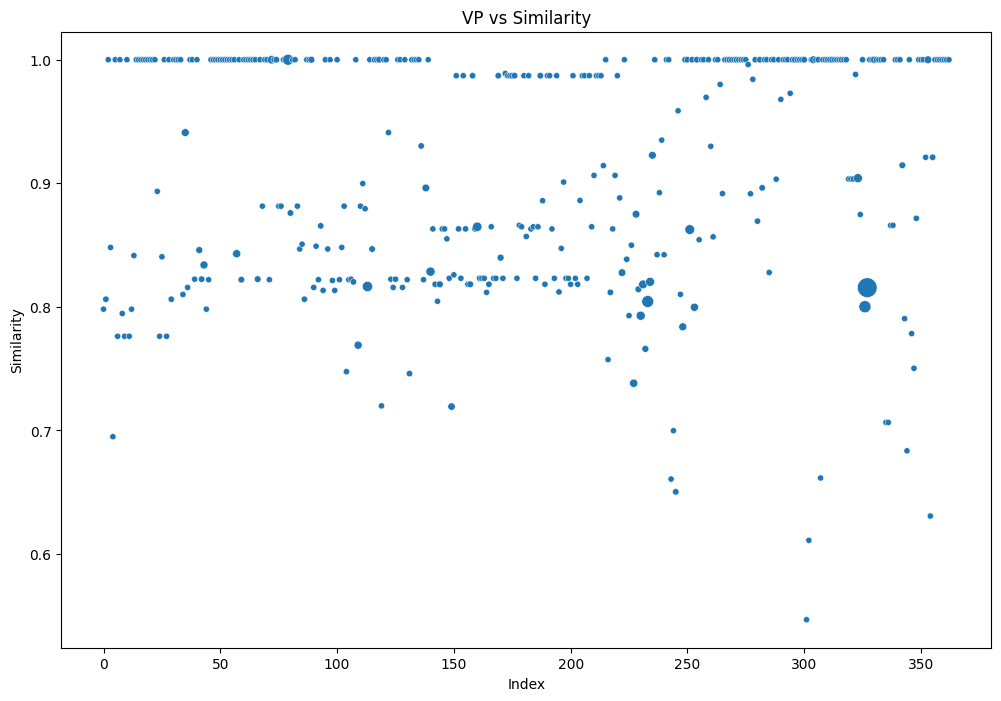

In [947]:
# create a plut that shows the similarity ratio and the vp where vp is te size of the circle

import matplotlib.pyplot as plt

df = pd.DataFrame(data_df_red)
df['index'] = df.index

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='index', y='similarity', size='vp', sizes=(20, 200), legend=None)

plt.title('VP vs Similarity')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.show()







In [949]:
data_df_red

,voter,vp,similarity
0,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,11310.000000,0.798168
1,0x8d470921050899284b451d6a65f4204eee4aaf8f,63627.000000,0.806208
2,0x8719a15457c5107417966873d2a4b16b8478b873,15000.177205,1.000000
3,0x67aa1a10f3b5fe18df6359456ed7b92f09e2cf59,10250.000000,0.848077
4,0x88cc33242d5ced328ce19b5c75e2ed0e13781299,16632.462621,0.694969
...,...,...,...
358,0x090928b9327258f9b12ed9dcb9f64fb00e37c872,25747.118974,1.000000
359,0xc38da808d0865005312fe99387f5228881539e9f,19600.000000,1.000000
360,0xb5ab290e152290b6bd5bdb04e23236d3f9d4aaec,17279.437411,1.000000
361,0x8f5c7cef4d9c6dae6fa645ca41b3a8c6ca2bafb8,22679.655114,1.000000


In [950]:
data_df

,voter,co-voter,similar_votes,total_votes,similarity_ratio,similarity
0,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,0x067b9bbbbc42d2ab9b9ab6bb62646daf7f344a76,4,4,1.0,0.798168
282,0x8d470921050899284b451d6a65f4204eee4aaf8f,0x2f8f5adb3a7ea90eb1dd0cd7d4df33736d235909,4,4,1.0,0.806208
580,0x8719a15457c5107417966873d2a4b16b8478b873,0xd92b50e95faa39fada60735432435e86eb936f0c,1,1,1.0,1.000000
1355,0x67aa1a10f3b5fe18df6359456ed7b92f09e2cf59,0x1fd8271f95b32ecffade04a2c93c7009b6fe7d5f,2,2,1.0,0.848077
1615,0x88cc33242d5ced328ce19b5c75e2ed0e13781299,0x1f99b2df41969c0b88517b55bf0426dd2ecf977c,3,3,1.0,0.694969
...,...,...,...,...,...,...
131351,0x090928b9327258f9b12ed9dcb9f64fb00e37c872,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.0,1.000000
131480,0xc38da808d0865005312fe99387f5228881539e9f,0xc8bdec0f09a4cf86d0245021bc0cae9ab24a2065,1,1,1.0,1.000000
131609,0xb5ab290e152290b6bd5bdb04e23236d3f9d4aaec,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.0,1.000000
131725,0x8f5c7cef4d9c6dae6fa645ca41b3a8c6ca2bafb8,0xf6bc0e3662a840dc1fd939652dcc793c3edfaa1e,1,1,1.0,1.000000


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

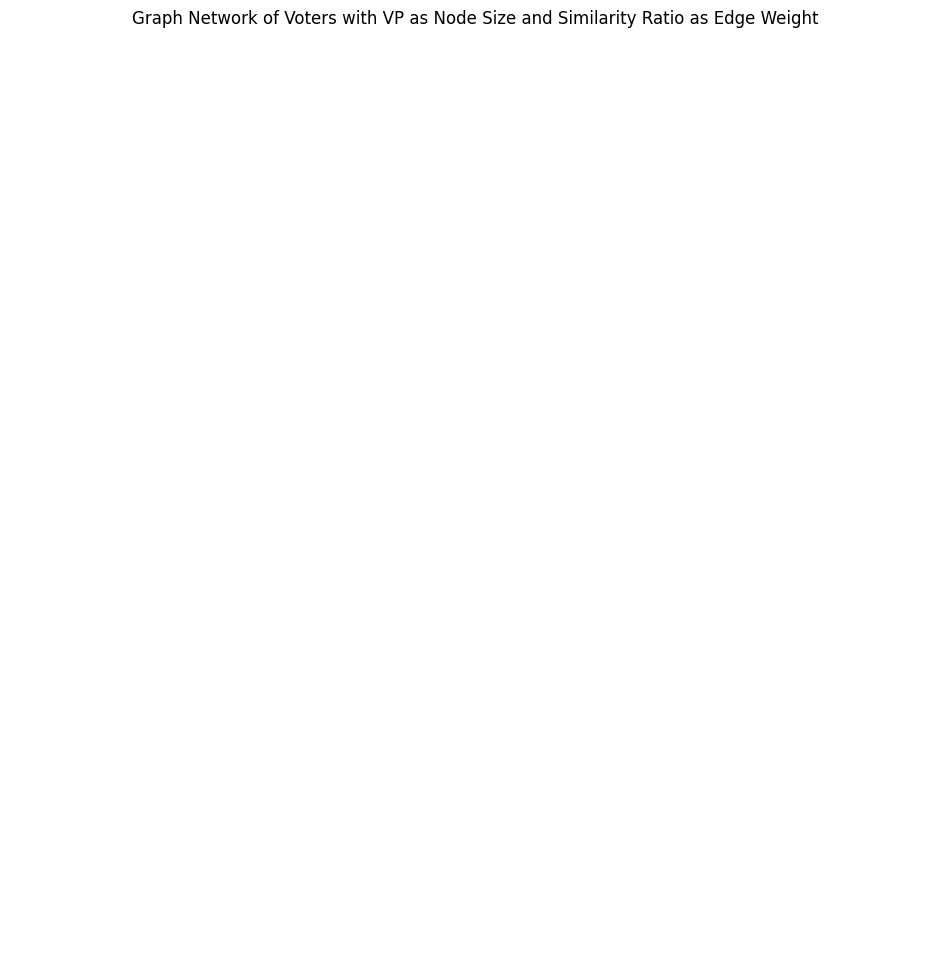

In [1004]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your data

# Create DataFrames
df_nodes = pd.DataFrame(data_df_red)
df_edges = pd.DataFrame(data_edges_df_merged)

# Create the graph
G = nx.Graph()

# Add nodes with size attribute
for idx, row in df_nodes.iterrows():
    G.add_node(row['voter'], size=row['vp'], similarity=row['similarity'])

# Add edges with weight attribute
for idx, row in df_edges.iterrows():
    # Ensure both nodes exist in the graph
    if row['voter'] not in G.nodes:
        G.add_node(row['voter'], size=1, similarity=0)  # Default size and similarity
    if row['co-voter'] not in G.nodes:
        G.add_node(row['co-voter'], size=1, similarity=0)  # Default size and similarity
    G.add_edge(row['voter'], row['co-voter'], weight=row['similarity_vp'])

# Check for any missing values in node positions and sizes
for node in G.nodes:
    if 'size' not in G.nodes[node]:
        G.nodes[node]['size'] = 1
    if 'similarity' not in G.nodes[node]:
        G.nodes[node]['similarity'] = 0

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)  # Adjust k for spacing between nodes

# Draw nodes with transparency
sizes = [G.nodes[node]['size'] / 1000 for node in G.nodes]  # Adjust node size
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='blue', alpha=0.6)

# Draw edges with different color and adjusted width
edges = G.edges(data=True)
weights = [np.log(edge[2]['weight'] * 2) or 0 for edge in edges]  # Scale edge weights for better visibility
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5, edge_color='red')

# Draw labels with reduced font size
nx.draw_networkx_labels(G, pos, font_size=1, font_color='black')

plt.title('Graph Network of Voters with VP as Node Size and Similarity Ratio as Edge Weight')
plt.axis('off')
plt.show()